# Assignment 3
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

This Jupyter Notebook is submitted as completion of the 3rd Assignment for the UCL course cited above.

## Setup
This cell imports the libraries and functions used in the assignment
and defines other helper functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl

from math import ceil
from numba import njit
from numpy.linalg import norm
from scipy.sparse.linalg import LinearOperator, cg, spilu, inv
from scipy.sparse import coo_matrix

def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N

## Question 1: Investigating Splitting Schemes
In this question, we seek to solve numerically the following Laplacian problem:
$$
-\Delta u (x, y) = 0
$$
for $x, y \in [0, 1]^2$, subject to these boundary conditions:
 * $u(x, 0) = 1$
 * $u(0, y) = 0$
 * $u(1, y) = 0$
 * $u(x, 1) = 0$

### Jacobi Iteration
#### Overview

In a first instance, we use the Jacobi Iteration method to find 
a solution. The unit square in question is discretised into a
lattice. Using a 5-point stencil, finite difference methodoligy,
each point in the lattice is the average of its neighboring 
points.

We repeat this opertion for each point on the lattice such that eahc operation on a point yields the next point in the iteration. These will eventually converge to a numerical solution.

The calculation is thus:

$$
u_{ij}^{(n+1)} = \frac{
u_{i-1, j}^{(n)} +
u_{i+1, j}^{(n)} +
u_{i, j-1}^{(n)} +
u_{i, j+1}^{(n)} }{4}
$$

#### Implementation

The above calculation is performed in an OpenCL kernel which itself
is wrapped in the SciPy Linear Operator class. After initialising it
with an array of ones the result of the kernel is repeatidly fed back
into it until the norm of the difference between iterations is less
than the specified tolerance.

The domain itself is discretised into $M$ points per side, including
the boundaries. The inner points are then extracted and flattened
row-wise into a 1-D array. It is this array to which the kernel is
repeatidly applied.

The implementation in this notebook is generalised to work with any boundary
function $f$. It accomplishes this by evaluating the values of all the discrete
points on the boundaries according to the function $f$. These valus are stored in
four respective arrays which are then passed and loaded into the kernel. The kernel
can then access these during its operation.

In [2]:
### Jacobi Iteration Implementation ###
class JacobiIterator(LinearOperator):
    """
    Implements an OpenCL-accelerated Linear Operator for
    perforing the Jacobi Iteration of of a 5-point stencil
    in the Laplacian problem for a unit square.
    """
    def __init__(self, M, left, right, top, bottom, data_type):
        """
        Creates the linear operator for M points per side
        and with the given boundary conditions.
        """
        # Setup parameters (required by parent class)
        self.shape = ((M-2)**2, (M-2)**2)
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        # Create the OpenCL kernel
        self._openCL_matvec = init_Jacobi_kernel(M, left, right, top, bottom)

    def _matvec(self, x):
        """
        Apply the Linear Operator to the vector x
        """
        return self._openCL_matvec(x)


def init_Jacobi_kernel(M, left, right, top, bottom):
    """
    Initialises an OpenCl kernel that implements a Jacobi Iterator
    for solving the Laplacian problem on a unit square,
    discretised into M points per side and with the given boundary
    conditions.
    """
    Mop = (M-2)**2
    # OpenCL kernel 
    kernel = """
        __kernel void matvec(
            __global double *vector,
            __global double *result,
            __global double *left,
            __global double *right,
            __global double *top,
            __global double *bottom,
            int N
        ){        
            // Get Global Identifiers i.e. the row index
            int row_index = get_global_id(0);
            int col_index = get_global_id(1);

            double left_val;
            double right_val;
            double top_val;
            double bottom_val;
            
            // Calculate stencil
            if (col_index == 0)
                left_val = left[row_index];
            else
                left_val = vector[N * row_index + col_index - 1];

            if (col_index == N-1)
                right_val = right[row_index];
            else
                right_val = vector[N * row_index + col_index + 1];

            if (row_index == 0)
                top_val = top[col_index];
            else
                top_val = vector[N * (row_index - 1) + col_index];

            if (row_index == N-1)
                bottom_val = bottom[col_index];
            else
                bottom_val = vector[N * (row_index + 1) + col_index];
            
            // Save result
            result[row_index * N + col_index] = 0.25*(left_val + right_val + top_val + bottom_val);
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create buffers
    vector_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    # These buffers contain the values of the lattice at
    # its boundaries
    left_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=left)
    right_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=right)
    top_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=top)
    bottom_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=bottom)
    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define Execution Function
    def kernel_exec(x):
        """
        Executes the created OpenCl kernel with the array x.
        """
        # Load vector x
        mapped_input, _ = cl.enqueue_map_buffer(queue, vector_buffer, cl.map_flags.WRITE, 
                                                0, Mop, 'float64')
        with mapped_input.base:
            mapped_input[:] = x.astype('float64')
        
        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (M-2, M-2), None,
            # Buffers
            vector_buffer, result_buffer,
            left_buffer, right_buffer, top_buffer, bottom_buffer,
            np.int32(M-2)
        )
        
        # read and return result
        result = np.empty(Mop, dtype='float64')
        cl.enqueue_copy(queue, result, result_buffer)
        queue.finish()
        
        return result
    # Return the kernel executor to the Linear Operator
    return kernel_exec


### Boundary Discretiser ###
def discretise_bc(low, high, M, f):
    """
    Discretise the function f into M points between the given
    values low and high.
    """
    x = np.linspace(low, high, M)
    fx = np.array([f(xi) for xi in x], dtype='float64')
    return fx


def get_boundary_values(xlims, ylims, f, M):
    """
    Evaluate the boundaries of the square for the given limits
    (xlims and ylims) according to the function f(x, y) for M
    evenly spaced points on each boundary.
    """
    left = discretise_bc(xlims[0], xlims[1], M, lambda x: f(x, ylims[0]))
    right = discretise_bc(xlims[0], xlims[1], M, lambda x: f(x, ylims[1]))
    top = discretise_bc(ylims[0], ylims[1], M, lambda y: f(xlims[1], y))
    bottom = discretise_bc(ylims[0], ylims[1], M, lambda y: f(xlims[0], y))
    return left, right, top, bottom

#### Solving 

Here we define and use a function to solve the system.

In [3]:
def jacobi_solve(xlims, ylims, M, f, max_k=1e4, tol=1e-8):
    """
    Solve numerically the Laplacian problem for a square with edges
    determined by the length-2 lists xlims and ylims. Each length of
    the square is discretised into M points (including the boundaries).
    The values of the square at the boundaries is given by the function
    f.
    """
    # Define boundaries
    left, right, top, bottom = get_boundary_values(xlims, ylims, f, M)

    # Create LOP that is aware of boundary conditions
    # without including the corner points of the square
    jlop = JacobiIterator(M, left[1:-1], right[1:-1],
                          top[1:-1], bottom[1:-1], 'float64')

    # Initialise results containers
    Mop = (M-2)**2
    result_old = np.zeros(Mop)
    result_new = np.ones(Mop)
    
    # Initialise iteration counter
    k = 0
    
    # Iterate    
    while norm(result_old - result_new) > tol:
        result_old = result_new
        result_new = jlop @ result_new
        k += 1
        if k > max_k:
            print('Max iteration achieved without converging!')
            break # break out of the iteration loop
    
    # Reformat the result into a square and include the
    # boundary conditions
    sol = np.pad(result_new.reshape((M-2, M-2)), 1)
    
    sol = np.flip(sol, 0)
    sol[0, :] = bottom
    sol[-1, :] = top
    sol[:, 0] = left
    sol[:, -1] = right
    return sol


def show_solution(xlims, ylims, sol, title):
    """
    Plot the solution including colourbar, title and axis labels
    """
    ax = plt.imshow(sol, origin='lower', extent=[xlims[0], xlims[1], ylims[0], ylims[1]])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    fig = plt.gcf()
    fig.dpi = 100
    plt.colorbar()
    plt.show()

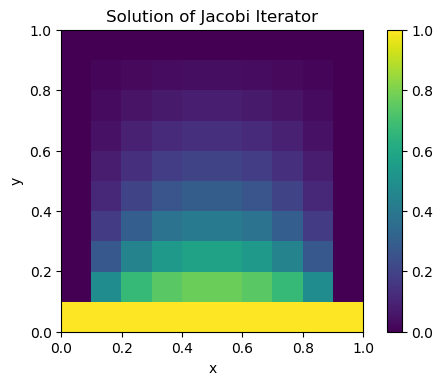

In [4]:
# Solve the Laplacian problem for the given function
# describing the boundary conditions
M = 10         # Number of descritsation points per length
xlims = [0, 1] # Bounds of the x-dimension
ylims = [0, 1] # Bounds of the y-dimension

# Define the boundary conditions
def f(x, y):
    """
    Describes the boundary conditions for the system
    """
    if x == 0:
        return 1
    else:
        return 0

# Solve and show
u = jacobi_solve(xlims, ylims, M, f)
show_solution(xlims, ylims, u, 'Solution of Jacobi Iterator')

### Gauss-Seidel Iteration (Forward and Backward Schemes)
#### Overview
In this section we implement the Gauss-Seidel Iteration for solving
the Laplace problem. This approach uses values calculated in the same
iteration to calculate new ones, effectivly updating one value at a time.
Working row by row, from left to right. 

#### Implementation
Because each value reuqires recently updated ones, it is not
pragmatic to parallelise this function. Consequently, we use the
Numba library to compile the function for better execution speed.
Similarly to the Jacobi Iteration, the values at the boundaries
are pre-computed from the given function $f$ and passed to the solver
as four arrays, which are accessed by the solver as needed.

The resulting vector is compared to its state before being applied to 
the algorithm and stops iterating if the norm of the difference
between these two is less than the specified tolerance.

In [5]:
@njit
def gauss_solve(xlims, ylims, M, left_bc, right_bc, top_bc, bottom_bc,
                tol= 1e-5, descending=True, max_k=10000):
    """
    Solve the Laplace problem for the given boundary conditions, discretising
    a square into M points per side (including the boundaries)
    """
    # Initialise iterator for working through rows
    if not descending:
        iterrange = range(1, M-1) # do not do the boundaries
    else:
        iterrange = range(M-2, 0, -1)

    # Initialise containers for results
    lattice = np.ones((M, M))
    old_lattice = np.zeros((M, M))
    history = []
    
    # Initialise counter
    k = 0
    
    # Iterate
    while norm(old_lattice - lattice) > tol:
        old_lattice[:] = lattice[:]
        for row in iterrange:
            for col in iterrange:
                if row == 1:
                    bottom = bottom_bc[col]
                else:
                    bottom = lattice[row-1, col]
                if row == M-2:
                    top = top_bc[col]
                else:
                    top = lattice[row+1, col]
                if col == 1:
                    left = left_bc[row]
                else:
                    left = lattice[row, col-1]
                if col == M-2:
                    right = right_bc[row]
                else:
                    right = lattice[row, col+1]

                lattice[row, col] = 0.25*(left + right + top + bottom)
        if k > max_k:
            print('Maximum number of iterations reached without convergence!')
            break
        history.append(norm(old_lattice - lattice))
        k += 1
        
    sol = lattice
    # Include the boundary conditions
    sol[:, 0] = left_bc
    sol[:, -1] = right_bc
    sol[0, :] = bottom_bc
    sol[-1, :] = top_bc

    return sol, history

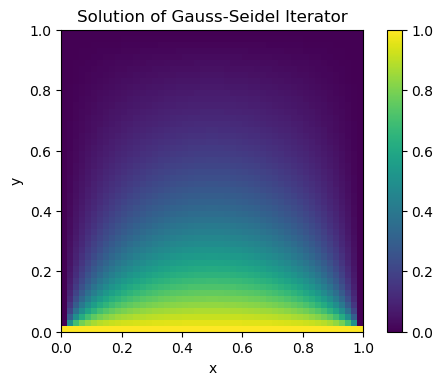

In [6]:
# Implemnt the solver with the following parameters
M = 50               # Number of points to descitise per length
xlims = (0, 1)       # Limits of x-dimension
ylims = (0, 1)       # Limits of y-dimension

# Solve direction
# True to go from top to bottom; False to go from bottom to top
descent_flag = True 

# Define the boundary conditions
def f(x, y):
    """
    Describes the boundary conditions for the system
    """
    if x == 0:
        return 1
    else:
        return 0

boundaries = get_boundary_values(xlims, ylims, f, M)
u, history = gauss_solve(xlims, ylims, M, *boundaries, descending=descent_flag)
show_solution(xlims, ylims, u, 'Solution of Gauss-Seidel Iterator')

### Relaxed Gauss-Seidel Iteration
#### Overview
The Relaxed Gauss-Seidel is similar to the previous algorithm,
but each element in a row independently. This allows for some
parallelisation.

#### Implemententation
We implement a kernel in OpenCL that parallelises the calculation
of each element in a row. Again the boundary conditions are
pre-calculated and passed to the kernel for access as needed.

The same methof for determining convergence is used as in the above
section.

In [7]:
class RelaxedGaussSeidel:
    """
    A container for an OpenCL method implementing the Relaxed Gauss Siedel Iterator for
    a square domain.
    """
    def __init__(self, M, left, right, top, bottom):
        """
        Initialises an OpenCl kernel that implements a Relaxed Gauss Seidel
        iterator for solving the Laplacian problem on a unit square,
        discretised into M points per side and with the given boundary
        conditions.
        """
        Mop = M-2
        # OpenCL kernel 
        kernel = """
            __kernel void matvec(
                __global double *previous_row,
                __global double *current_row,
                __global double *next_row,
                __global double *result,
                __global double *left,
                __global double *right,            
                __global double *top,
                __global double *bottom,
                int row_index,
                int N
            ){        
                // Get Global Identifiers i.e. the row index
                int col_index = get_global_id(0);

                double top_val;
                double bottom_val;
                double left_val;
                double right_val;


                if (col_index == 0)
                    left_val = left[row_index];
                else
                    left_val = current_row[col_index - 1];

                if (col_index == N-1)
                    right_val = right[row_index];
                else
                    right_val = current_row[col_index + 1];

                if (row_index == N-1)
                    top_val = top[col_index];
                else
                    top_val = next_row[col_index];

                if (row_index == 0)
                    bottom_val = bottom[col_index];
                else
                    bottom_val = previous_row[col_index];

                result[col_index] = 0.25*(left_val + right_val + top_val + bottom_val);
            }
        """
        # Initialise the OpenCL environment
        ctx = cl.create_some_context()
        queue = cl.CommandQueue(ctx)
        mf = cl.mem_flags

        # Create buffers
        previous_row_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
        current_row_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
        next_row_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
        result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
        left_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=left)
        right_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=right)
        top_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=top)
        bottom_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=bottom)

        # Build the Kernel
        prg = cl.Program(ctx, kernel)
        prg.build()
        matvec_kernel = prg.matvec

        # Define Execution Function
        def kernel_exec(previous_row, current_row, next_row, current_row_index):
            """
            Executes the created OpenCl kernel with the array x.
            """
            # Load previous row
            mapped_input, _ = cl.enqueue_map_buffer(queue, previous_row_buffer, cl.map_flags.WRITE, 
                                                 0, Mop, 'float64')
            with mapped_input.base:
                mapped_input[:] = previous_row.astype('float64')
            
            # Load current row
            mapped_input, _ = cl.enqueue_map_buffer(queue, current_row_buffer, cl.map_flags.WRITE, 
                                                 0, Mop, 'float64')
            with mapped_input.base:
                mapped_input[:] = current_row.astype('float64')
            
            # Load next row
            mapped_input, _ = cl.enqueue_map_buffer(queue, next_row_buffer, cl.map_flags.WRITE, 
                                                 0, Mop, 'float64')
            with mapped_input.base:
                mapped_input[:] = next_row.astype('float64')


            # Run the kernel
            matvec_kernel(
                # Workspace parameters
                queue, (Mop,), None,
                # Buffers
                previous_row_buffer,
                current_row_buffer,
                next_row_buffer,
                result_buffer,
                left_buffer, right_buffer,
                top_buffer, bottom_buffer,
                np.int32(current_row_index),
                np.int32(Mop)
            )

            # read and return result
            result = np.empty(Mop, dtype='float64')
            cl.enqueue_copy(queue, result, result_buffer)
            queue.finish()

            return result
    
        self.run_kernel = kernel_exec
    
    def calc_row(self, previous_row, current_row, next_row, current_row_index):
        """
        Executes the previously made kernel.
        """
        return self.run_kernel(previous_row, current_row, next_row, current_row_index)


def relaxed_gauss_solve(xlims, ylims, M, left_bc, right_bc, top_bc, bottom_bc,
                        tol=1e-5, max_k=10000):
    """
    Solve the Laplacian problem using the Relaxed Gauss Seidel algorithm.
    """
    Mop = (M-2)**2
    # Create LOP that is aware of boundary conditions (excluding corner points)
    rgslop = RelaxedGaussSeidel(M, left_bc[1:-1], right_bc[1:-1], top_bc[1:-1], bottom_bc[1:-1])
    
    # Initialise containers for result
    result_old = np.zeros((M-2, M-2))
    result_new = np.ones((M-2, M-2))
    history = []
    
    # Initialise counter
    k = 0
    
    # Iterate
    while norm(result_old - result_new) > tol:
        result_old = result_new.copy()
        for current_row_index, current_row in enumerate(result_new):
            previous_row = result_new[current_row_index - 1, :] if current_row_index > 0 else np.zeros(M-2)
            next_row = result_new[current_row_index + 1, :] if current_row_index < M-3 else np.zeros(M-2)
            result_new[current_row_index, :] = rgslop.calc_row(previous_row, current_row, next_row, current_row_index)
        history.append(norm(result_old - result_new))
        k += 1
        if k > max_k:
            print('Maximum number of iterations achieved without convergence')
            break # break out of the loop
            
    sol = np.pad(result_new, 1)
    sol[:, 0] = left_bc
    sol[:, -1] = right_bc
    sol[0, :] = bottom_bc
    sol[-1, :] = top_bc
    
    return sol, history

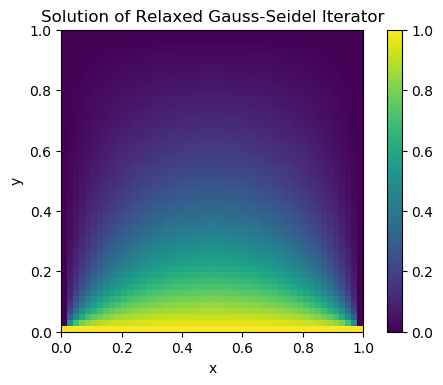

In [8]:
# Setup
M = 50
xlims = (0, 1)
ylims = (0, 1)

def f(x, y):
    if x == 0:
        return 1
    else:
        return 0

# Solve and Show
boundaries = get_boundary_values(xlims, ylims, f, M)
u, history = relaxed_gauss_solve(xlims, ylims, M, *boundaries)
show_solution(xlims, ylims, u, 'Solution of Relaxed Gauss-Seidel Iterator')

### Convergence Comparison: Relaxed GS vs. GS

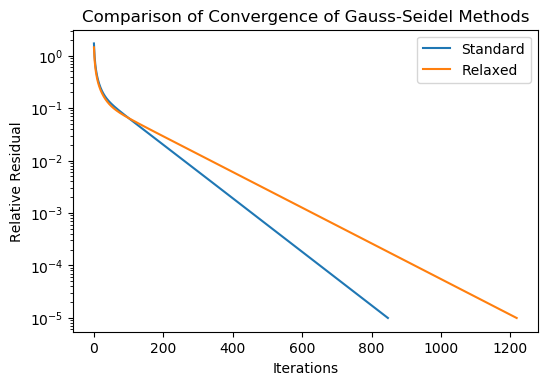

In [9]:
M = 30
xlims = (0, 1)
ylims = (0, 1)

def f(x, y):
    """
    Define boundary conditions
    """
    if x == 0:
        return 1
    else:
        return 0
    
boundaries = get_boundary_values(xlims, ylims, f, M)
u, history_gauss = gauss_solve(xlims, ylims, M, *boundaries, descending=False)
u, history_relax = relaxed_gauss_solve(xlims, ylims, M, *boundaries)
    
iters_gauss = [i for i, _ in enumerate(history_gauss[1:])]
iters_relax = [i for i, _ in enumerate(history_relax[1:])]

plt.semilogy(iters_gauss, history_gauss[1:], label='Standard')
plt.semilogy(iters_relax, history_relax[1:], label='Relaxed')
plt.xlabel('Iterations')
plt.ylabel('Relative Residual')
plt.title('Comparison of Convergence of Gauss-Seidel Methods')
fig = plt.gcf()
fig.dpi = 100
plt.legend()
plt.show()

**Analysis:** Both methods converge exponentially, yet still at different rates. This is especially noticeable for problems with large values of $M$. The standard Method converges in many less iterations than the Relaxed one.

## Question 2: Precondition Iterative Solvers
#### Overview
In this question, we write a routine that for a given step-size $h$ generates
a 5-point stencils discretisation of an L-shaped domain and solves the Laplacian
problem on this domain for boundary conditions set by the function f.

The domain $Omega$ itself is defined by the following: 

$\Omega := \Omega_1 \cup \Omega_2$ with $\Omega_1 := [−1, 0]×[−1, 1]$ and $\Omega_2 := [−1, 1]×[0, 1]$

After implementing a solver with the Conjugate Gradient method, we subsequently
analyse the convergence of the created solver as-is versus when implemented
with a preconditioner derived from Incomplete LU decomposition.

#### Implementation
We begin by excluding the boundaries and then dividing the L-domain
into two sections, as represented below (each number represents a
point in the descretisation). Numbers 14 and below represent first
section, numbers strictly above 14 represent second section. Discretisations
with smaller step-sizes follow the same pattern.
```
+-----------------------+
|31 32 33 34 35 36 37 38|
|23 24 25 26 27 28 29 30|
|15 16 17 18 19 20 21 22|
|12 13 14+--------------+
| 9 10 11|
| 6  7  8|
| 3  4  5|
| 0  1  2|
+--------+
```

We then flatten this domain into a 1-D array and implement an
algorithm to construct an operator $A$ which applies a 5-point stencil
to this domain such that
$$ A u = b$$
where $u$ is the flattened array of the domain and b represents both the divergence
of the gradient and the boundary conditions.

In a second instance we use the SciPy library to create an ILU decomposition to estimate
of the operator $A$, which we then pass it to the CG solver.

##### Create 5-point stencil matrix

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from numba import njit
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import coo_matrix


def isbc(i, j, M):
    """
    Check if the given point (i, j) is a boundary condition in the 
    descretisation of the space into M points per unit.
    """
    if i < M: # Lower section
        if i == 0 or j == M - 1 or j == 0:
            return True
    else:     # Bottom section
        if j == 0 or j == 2*M - 1:
            return True
        if i == M and j >= M - 1:
            return True
        if i == 2*M-1:
            return True
    # If no conditions match, return False
    return False


def isvalid(i, j, M):
    """
    Checks if the given point belongs to the domain space.
    """
    if j >= M and i < M:
        return False
    else:
        return True
    

def build_system(h, f, grad=0):
    """
    Buid the matrix that embodies the 5-point stencil descritisation for the 
    L-shaped space for a given step size h.
    """
    # Define M and round h such that M and h are equivalent
    M = int(round(1/h))
    h = 1/M
    
    # Initialise containers for buidling the COO-formatted matrix
    data = []
    rows = []
    cols = []
    
    # Initialise container for later remapping the solution to an image
    solmap = {}
    
    # Define the size of the matrix
    Mop = 3*(M-2)**2 + 4*(M-2)
    
    # Initialise the matrix 
    b = np.ones(Mop)*grad*h**2
    
    # Define here for convenience with containers as 'global' variables
    def add(val, row, colshift):
        """
        Add coefficient to operator
        """
        data.append(val)
        rows.append(row)
        if row+colshift < 0:
            raise Exception(f'Negative col index {row}: {colshift}')
        cols.append(row+colshift)
    
    # Initiate counter
    k = 0
    
    # Iterate
    for i in range(2*M): # i = rows
        for j in range(2*M): # j = columns
            if not isbc(i, j, M) and isvalid(i, j, M):
                if i <= M:
                    k = (i-1)*(M-2) + (j-1)
                else:
                    k = M*(M-2) + (i-1-M)*(2*M-2) + (j-1)
                solmap[k] = (i, j)
                # BCs
                # top
                if isbc(i+1, j, M):
                    b[k] += f((i+1)/M, j/M)
                # bottom
                if isbc(i-1, j, M):
                    b[k] += f((i-1)/M, j/M)
                # left
                if isbc(i, j-1, M):
                    b[k] += f(i/M, (j-1)/M)
                # right
                if isbc(i, j+1, M):
                    b[k] += f(i/M, (j+1)/M)
                ## Finite Difference coefficients
                # center
                add(4, k, 0)
                
                # if lower section:
                if i <= M:
                    # left
                    if j >= 2:
                        add(-1, k, -1)
                    
                    # right
                    if j <= M - 3:
                        add(-1, k, 1)
                    
                    # top
                    add(-1, k, M-2)
                    
                    # bottom
                    if i >= 2:
                        add(-1, k, -(M-2))
                else: # if upper section
                    # left
                    if j >= 2:
                        add(-1, k, -1)
                    
                    # right
                    if j <= 2*M-3:
                        add(-1, k, 1)
                    
                    # top
                    if i <= 2*M-3:
                        add(-1, k, 2*(M-1))
                    
                    # bottom
                    if i == M+1 and j <= M - 2:
                        add(-1, k, -(M-2))
                    elif i >= M+2:
                        add(-1, k, -2*(M-1))
                
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        print(cols)
        raise Exception('Negative column index')

    A = coo_matrix((data, (rows, cols))).tocsc()
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        return A, b
        raise Exception(f'Matrix is not square: {A.shape}')
    
    # Ensure its the expected size
    if A.shape[0] != Mop:
        raise Exception(f'Matrix wrong size:{A.shape[0]}')
    
    return A, b, M, solmap

##### Solve with CG

In [11]:
def solve(A, b, P=None, maxiter=None):
    """
    Use the CG method to solve the system Ax=b, returning both the solution
    and the convergence profile of the plot.
    """
    # Initialise container
    history = []
    
    def error_calc(u):
        """
        Local function to exctract error from plot.
        """
        error = np.linalg.norm(A@u - b)
        history.append(error)

    # Execute CG method
    sol, info = cg(A, b, maxiter=maxiter, callback=error_calc, M=P)
    
    # Check convergence status of solution
    if info > 0:
        print('Did not converge! iter:', info)
    if info < 0:
        print('There was an error in cg')
    
    return sol, history

##### Visualise

In [12]:
def show(u, M, f, solmap):
    """
    Use the given solution map to recreate the L-shaped domain from the given
    flattened array.
    """
    # Initialise array shape
    im = np.zeros((2*M, 2*M))

    # Extract solution into shape
    for k, (i, j) in solmap.items():
        im[i, j] = u[k]
    
    # Set the boundary conditions
    for i in range(2*M):
        for j in range(2*M):
            if isbc(i, j, M):
                im[i, j] = f(i, j)
    
    # Set the invalid points to NaNs so they dont appear in plot
    im[:M, M:] = np.nan
        
    plt.imshow(im, origin='lower', extent=[-1, 1, -1, 1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Solution of the Method')
    fig = plt.gcf()
    fig.dpi = 100
    plt.colorbar()
    plt.show()
    return im

##### Run the Code Here

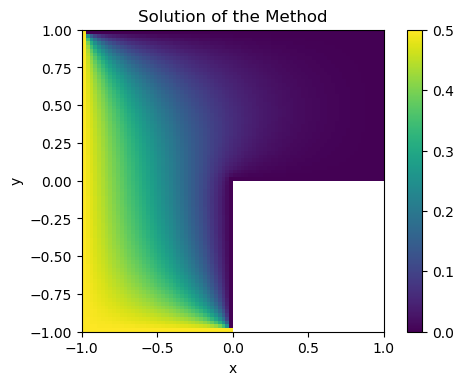

In [13]:
h = 0.025

def f(x, y):
    """
    Boundary condition function
    """
    if y == 0 or x == 0:
        return 0.5
    else:
        return 0
    
A, b, M, solmap = build_system(h, f)
sol, history = solve(A, b)
show(sol, M, f, solmap);

#### Study Convergence

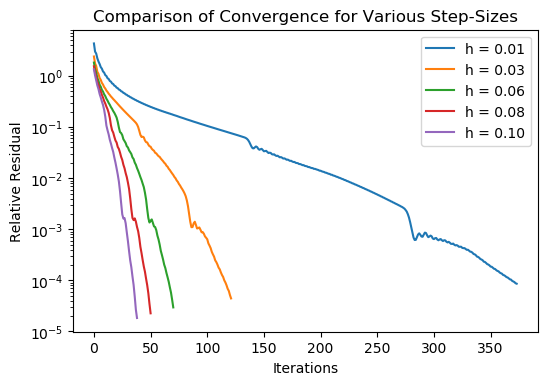

In [14]:
def convergence_study(start, end, iters, Pflag=False):
    """
    Run multiple solves for different step parameters and plot the 
    convergence rates.
    """
    hs = np.linspace(start, end, iters)
    for h in hs:
        # Build and Solve
        A, b, M, solmap = build_system(h, f)
        sol, history = solve(A, b, None)
        # Plot Convergence
        iters = [i for i, _ in enumerate(history)]
        plt.semilogy(iters, history, label='h = %.2f'%h)
    plt.xlabel('Iterations')
    plt.ylabel('Relative Residual')
    plt.title('Comparison of Convergence for Various Step-Sizes')
    fig = plt.gcf()
    fig.dpi = 100
    plt.legend()
    plt.show()

convergence_study(0.01, 0.1, 5)

### Impact of ILU Preconditioner

In [15]:
def create_preconditioner(A, dt):
    """
    Using SPILU and a specified drop tolerance, create a preconditioner
    for A.
    """
    ilu = spilu(A, drop_tol=dt)
    Mx = lambda x: ilu.solve(x)
    N = A.shape[0]
    P = LinearOperator((N, N), Mx)
    return P


def study_ilu_convergence(h, f, *drop_tol_list):
    """
    For a system of size h, apply Scipy's ILU rountine
    for various drop factors and compare the rates of convergence for each
    run.
    """
    A, b, M, solmap = build_system(h, f)
    for dt in drop_tol_list:
        P = create_preconditioner(A, dt)
        sol, history = solve(A, b, P, maxiter=200)
        iters = [i for i, _ in enumerate(history)]
        plt.semilogy(iters, history, label=f'drop:{dt}')

    plt.xlabel('Iterations')
    plt.ylabel('Relative Residual')
    plt.title('Comparison of Convergence for Various Drop Factors')
    plt.legend(loc='upper right')
    fig = plt.gcf()
    fig.dpi = 100
    plt.show()

Did not converge! iter: 200
Did not converge! iter: 200
Did not converge! iter: 200


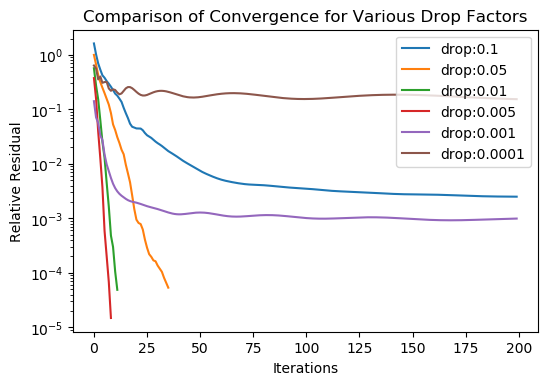

In [16]:
h = 0.025

def f(x, y):
    """
    Boundary condition function
    """
    if y == 0 or x == 0:
        return 0.5
    else:
        return 0

study_ilu_convergence(h, f, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 1e-4)  

**Analysis:** Implementing the ILU to obtain a preconditioner can significantly improve the convegrence rate of the conjugate gradient method. The drop tolerance is nonetheless an important parameter in tuning the performance of the algorithm: too large or too small and it will prevent the algorithm from converging to the desired level. For $h = 0.25$, a drop factor of approximately $0.005$ greatly increases the convergence rate.